#  RNN: How To Implement A Basic Recurrent Neural Networks

### Read In, Clean, And Split The Data

In [3]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]

messages.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [4]:
labels = np.where(messages['label']=='spam', 1, 0) # If the label is spam, then set it equal to 1. 
                                                   # Otherwise, set it equal to 0
# First 5 elements
labels[:5]

array([0, 0, 1, 0, 0])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                                    messages['text'],  # Feature data: the text messages
                                                    labels,            # Target data: the corresponding labels (0 for ham, 1 for spam)
                                                    test_size=0.2      # 20% of the data will be used for testing
                                                    )

X_train.head()

2408                                                                                                              Dear where you will be when i reach there
830     U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd. Cust care 07821230901
1539                              You're not sure that I'm not trying to make xavier smoke because I don't want to smoke after being told I smoke too much?
5021                                                                                              Yes its possible but dint try. Pls dont tell to any one k
2082                                                                                                                                      I'm done oredi...
Name: text, dtype: object

### Prep Data For Modeling

In [7]:
# Install keras
#!pip install -U keras
#!pip install tensorflow -U

In [8]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

So, let's start with the `Tokenizer`. This will serve a similar purpose to the simple pre-process function from Jensen and that will clean and tokenize our data. So, the first thing we need to do is instantiate our Tokenizer. And we'll just store it as an object called Tokenizer. 

And then we'll take that Tokenizer object, and we're going to call `.fit_on_texts`, and then we'll pass in our training data. And what this method will do is clean and tokenize our texts. Then, it's going to build a vocabulary of all of the words in our training set. And then it's going to assign each word an index.

We can call this text to sequences method from the trained Tokenizer and then we'll just pass in our training set. And what this is going to do, is it's rephrase. And what this is going to do is it's going to convert our text message string into a list of integers, where each integer represents the index of that word in the train Tokenizer. 

In [10]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()          # Create a new Tokenizer instance
tokenizer.fit_on_texts(X_train)  # Fit the tokenizer on the training text data to build the vocabulary

# Use the fitted tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)  # Convert the training text messages to sequences of integers
X_test_seq = tokenizer.texts_to_sequences(X_test)    # Convert the test text messages to sequences of integers

# Display the sequences for the first text message in the training set
X_train_seq[0]  # Show the sequence of integers representing the first training message

[110, 126, 3, 29, 33, 43, 1, 428, 69]

So, this is the integer representation of the first text message in our data set. So again, each integer here is representing a word in the first text message.

Now the last thing we need to do to prepare our data is standardize the length of our sequences. As of now, the list of integers will be the same length as the text message. And recall we previously learned that machine learning models expect the same number of features for every example that it sees. So in our terms, the RNN model requires each sentence, or each list of integers to be the same length. So the way that we handle this for an RNN is with a function called `pad_sequences`.

The last thing we need to do is just tell Keras what length we want all of our sequences to be. So you can experiment with this, but let's just set it to 50. So now what this will do is it will say for a given sequence, if it's longer than 50, then it will just truncate the sequence to a maximum of 50. If it's shorter than 50, then it will satisfy the length requirement by padding the sequence with zeros.

In [12]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=50)  # Pad the training sequences to ensure they are all 50 tokens long
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=50)    # Pad the test sequences to ensure they are all 50 tokens long

# Display the padded sequence for the first text message in the training set
X_train_seq_padded[0]  # Show the padded sequence of integers for the first training message

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 110, 126,   3,  29,  33,  43,   1, 428,  69])

### Build Model

In [14]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
    
    # Calculate true positives: The sum of correctly predicted positive samples
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    # Calculate possible positives: The sum of all actual positive samples
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    # Compute recall: The ratio of true positives to possible positives
    recall = true_positives / (possible_positives + K.epsilon())
    
    return recall

def precision_m(y_true, y_pred):
    
    # Calculate true positives: The sum of correctly predicted positive samples
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    # Calculate predicted positives: The sum of all predicted positive samples
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    # Compute precision: The ratio of true positives to predicted positives
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return precision

# Benefits:
# 1. Custom Metrics: These functions define custom recall and precision metrics that can be used to evaluate the performance of a model.
# 2. Handle Imbalance: They help measure how well the model identifies positive samples, which is crucial in cases where the dataset is imbalanced.
# 3. Avoid Division by Zero: Using K.epsilon() prevents division by zero, ensuring that the metric calculations do not encounter numerical issues.

First, we're going to add an embedding layer. So do that with model.add embedding. What this is going to do is it'll take the text message that's being passed in and create an embedding or vector representation of that text. This should sound familiar. That's what Word2Vec and Doc2Vec does.

The difference with an RNN is it bakes that right into the model. So to step within the model itself, instead of two separate steps like we did with Word2Vec and Doc2Vec where we created the embeddings, and then we trained a random forest model on top of those embeddings. So now that we're telling the model we want the first layer to be an embedding layer, we have to tell it what the dimensionality of the input is, which basically means how many total words are there.

The first thing we need to do is pass in the input dimensionality, which basically means how many total words are there. We can do this by just calling the length on the tokenizer that we fit in the last video and calling the index_word attribute. And we'll add one to that to get the full dimensionality. So that'll tell the embedding layer how many words to expect as its input.

Then we need to tell it what the output dimensionalities should be. Now, you can explore this on your own. And remember when we looked at Word2Vec and Doc2Vec, we created the embeddings of length 100. We're going to go with something else this time. So let's go with output dimensionally of 32. So again, this will create embeddings of length 32.

In [16]:
# Construct a simple RNN model
model = Sequential()  # Initialize a Sequential model

model.add(Embedding(len(tokenizer.index_word)+1,  # Add an Embedding layer with vocab size (based on tokenizer)
                    32))                          # Embedding dimensions set to 32

model.add(LSTM(32,                    # Add an LSTM layer with 32 units
               dropout=0,             # No dropout for the input connections
               recurrent_dropout=0))  # No dropout for the recurrent state

model.add(Dense(32,                  # Add a Dense layer with 32 units
                activation='relu'))  # Use ReLU activation for non-linearity

model.add(Dense(1,                      # Add a final Dense layer with 1 unit
                activation='sigmoid'))  # Use sigmoid activation for binary classification

model.summary()  # Print the model summary to show the layer details

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          257472    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 266881 (1.02 MB)
Trainable params: 266881 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Compile the model
model.compile(optimizer='adam',                             # Set the optimizer to Adam
              loss='binary_crossentropy',                   # Set the loss function to binary cross-entropy for binary classification
              metrics=['accuracy', precision_m, recall_m])  # Evaluate the model using accuracy, precision, and recall metrics

In [18]:
# Fit the RNN model
history = model.fit(X_train_seq_padded,                           # Training data (padded sequences)
                    y_train,                                      # Training labels
                    batch_size=32,                                # Number of samples per gradient update
                    epochs=10,                                    # Number of epochs to train the model
                    validation_data=(X_test_seq_padded, y_test))  # Validation data to evaluate the model after each epoch  

Epoch 1/10
140/140 [==============================] - 3s 11ms/step - loss: 0.2410 - accuracy: 0.9199 - precision_m: 0.5415 - recall_m: 0.4498 - val_loss: 0.0517 - val_accuracy: 0.9874 - val_precision_m: 0.9902 - val_recall_m: 0.9190
Epoch 2/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0341 - accuracy: 0.9906 - precision_m: 0.9757 - recall_m: 0.9369 - val_loss: 0.0382 - val_accuracy: 0.9883 - val_precision_m: 0.9759 - val_recall_m: 0.9319
Epoch 3/10
140/140 [==============================] - 1s 8ms/step - loss: 0.0150 - accuracy: 0.9966 - precision_m: 0.9920 - recall_m: 0.9695 - val_loss: 0.0430 - val_accuracy: 0.9883 - val_precision_m: 0.9902 - val_recall_m: 0.9300
Epoch 4/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0059 - accuracy: 0.9984 - precision_m: 0.9929 - recall_m: 0.9827 - val_loss: 0.0479 - val_accuracy: 0.9874 - val_precision_m: 0.9902 - val_recall_m: 0.9205
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - los

The goal here is to understand how the model is performing on the training set and test sets across each metric. But also to know if our selection of 10 epoch is reasonable. If it's not enough epochs, then we'll be able to tell that we're under fitting our data, by the fact that performance will still be improving by the 10th epoch. If it's too many epochs, we'll see performance start to decrease due to over-fitting.

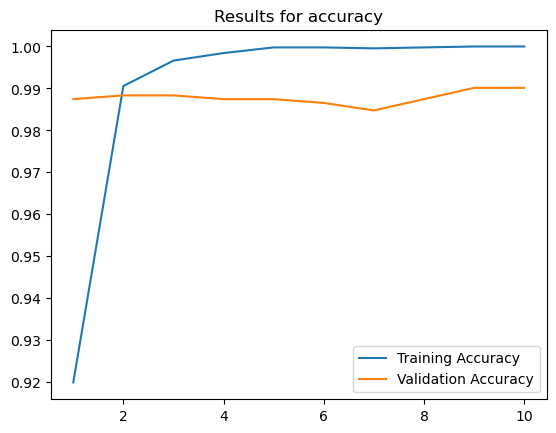

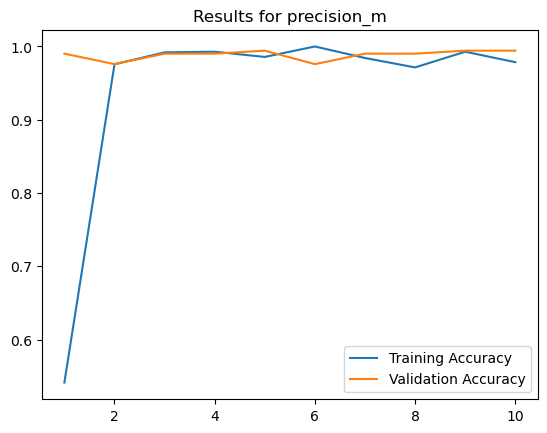

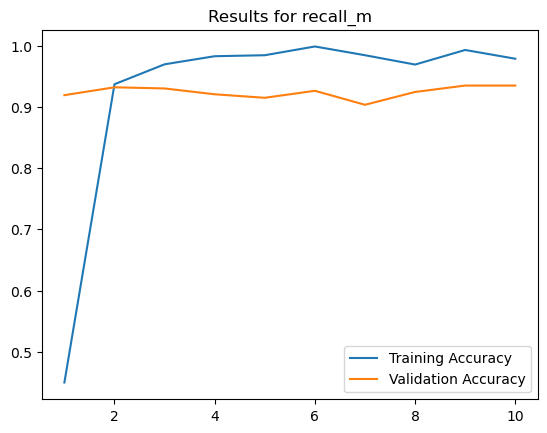

In [20]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

# Iterate over the metrics to plot their values
for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]                       # Training metric values
    val_acc = history.history['val_{}'.format(i)]  # Validation metric values
    epochs = range(1, len(acc) + 1)                # Range of epoch numbers

    plt.figure()                                            # Create a new figure for each plot
    plt.plot(epochs, acc, label='Training Accuracy')        # Plot training metric values
    plt.plot(epochs, val_acc, label='Validation Accuracy')  # Plot validation metric values
    plt.title('Results for {}'.format(i))                   # Set plot title
    plt.legend()                                            # Add a legend to the plot
    plt.show()                                              # Display the plot

So for **accuracy**, you could see that training accuracy improves with every epoch, which is always expected. The model will always learn more from the data, but the validation accuracy remains somewhat consistent all the way across. 

The same as mostly true for **precision**. Again, the validation performance remains pretty consistent across all epochs. 

And again, the same for **recall**. So this tells us that we probably don't need 10 epochs. It doesn't seem like the model is really learning anything after the first maybe couple passes through the data. And you can see that training accuracy exceeds validation accuracy, but not enough to be too concerned about the model being over fit to our training data. 